# Requirements and imports

In [ ]:
#requirements
!pip install wikidata
!pip install wikipedia
!pip install datasets
!pip install -q pandas beautifulsoup4
!pip install -q pandas requests
!pip install spacy
!python -m spacy download en_core_web_lg

!pip install -U transformers
#!pip install accelerate -U
!pip install evaluate
!pip install custom_model
!pip install torch

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=4e431f1da09bd745ad8cc6926caf25867bade1e8a15d9d4340dff77a121a5d6a
  Stored in directory: /root/.cache/pip/wheels/8f/ab/cb/45ccc40522d3a1c41e1d2ad53b8f33a62f394011ec38cd71c6
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are insta

In [ ]:
# Standard libraries
import os
import re
import time
import zipfile
import random
from datetime import datetime, timedelta
from urllib.parse import quote
from typing import Dict

# Data manipulation and web scraping
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm

# NLP tools
import nltk
from nltk.corpus import stopwords
import spacy

# Numerical computations and visualization
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Torch and Transformers
import torch
import torch.nn as nn
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    Trainer,
    TrainingArguments,
    set_seed,
    TrainerCallback,
    EarlyStoppingCallback,
    RobertaModel,
    RobertaPreTrainedModel
)
import transformers
import evaluate

# HuggingFace datasets
from datasets import load_dataset, Dataset

# Google Colab
from google.colab import files
from google.colab import drive

# Wikidata
from wikidata.client import Client

# NLTK data download
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Dataset Loading

In [ ]:
drive.mount('/content/drive')
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/AleBERTs&FraBERT_shared_folder/dataset_test.csv") #USE TEST SET
df_train=pd.read_csv("/content/drive/MyDrive/AleBERTs&FraBERT_shared_folder/dataset_train_enrich.csv")
df_val=pd.read_csv("/content/drive/MyDrive/AleBERTs&FraBERT_shared_folder/dataset_validation_enrich.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Features extraction and dataset enrichment

Numerical data

In [ ]:
#get number of properties in the wikipedia pages
def get_num_properties(qid):
    if not qid: return 0
    try:
        res = requests.get(WIKIDATA_API, params={"action": "wbgetentities", "ids": qid, "format": "json"}, timeout=10)
        return len(res.json().get("entities", {}).get(qid, {}).get("claims", {}))
    except: return 0

#get the number of languages available for an entity
def get_num_languages(qid):
    try:
        entity = client.get(qid, load=True)
        return len(entity.data.get('sitelinks', {}))
    except: return 0

# Get the title of the english wikipedia page
def get_en_wikipedia_title(qid):
    try:
        r = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{qid}.json', headers=HEADERS)
        r.raise_for_status()
        return r.json()['entities'][qid]['sitelinks']['enwiki']['title']
    except: return None

#Get the average number of views of the english wikipedia page
def get_average_daily_views(title):
    if not title: return None
    end = datetime.today() - timedelta(days=1)
    start = end - timedelta(days=30)
    url = f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/all-agents/{quote(title)}/daily/{start:%Y%m%d}/{end:%Y%m%d}'
    try:
        r = requests.get(url, headers=HEADERS)
        r.raise_for_status()
        views = [d['views'] for d in r.json().get('items', [])]
        return sum(views) // len(views) if views else None
    except: return None

def get_english_wikipedia_url(qid):
    try:
        url = f"https://www.wikidata.org/wiki/Special:EntityData/{qid}.json"
        r = requests.get(url, headers=HEADERS)
        r.raise_for_status()
        data = r.json()
        sitelinks = data['entities'][qid].get('sitelinks', {})
        enwiki = sitelinks.get('enwiki', {})
        return enwiki.get('url')
    except Exception as e:
        print(f"[URL_API] error in taking the qid {qid}: {e}")
        return None

#Get the total number of words in the english wikipedia page
def get_word_count_from_wikipedia(url, idx=None):
    try:
        if not url:
            print(f"[{idx}] URL is None")
            return 0
        response = requests.get(url, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            print(f"[{idx}] Request failed with status {response.status_code} → {url}")
            return 0

        soup = BeautifulSoup(response.text, 'html.parser')

        if "Wikipedia does not have an article with this exact name" in soup.text:
            print(f"[{idx}] Wikipedia page not found → {url}")
            return 0

        content = soup.find('div', {'id': 'mw-content-text'})
        if not content:
            print(f"[{idx}] No content found in div#mw-content-text → {url}")
            return 0

        text = content.get_text(" ", strip=True)
        word_count = len(text.split())
        if word_count == 0:
            print(f"[{idx}] Content found but word count is 0 → {url}")

        return word_count

    except Exception as e:
        print(f"[{idx}] Exception in get_word_count_from_wikipedia: {e} → {url}")
        return 0



Word data

In [ ]:
#Get property given an entity
def get_label(entity, pid):
    try:
        prop = entity[client.get(pid)]
        if isinstance(prop, list):
            return ', '.join(p.label.get('en', 'null') for p in prop)
        return prop.label.get('en', 'null')
    except Exception:
        return 'null'


#Return selected properties
def get_entity_data(qid):
    try:
        entity = client.get(qid, load=True)
        return {
            'instance_of': get_label(entity, 'P31'),
            'country': get_label(entity, 'P17'),
            'country_of_origin': get_label(entity, 'P495'),
            'English_description': entity.description.get('en', 'null')
        }
    except Exception:
        return {
            'instance_of': 'null',
            'country': 'null',
            'country_of_origin': 'null',
            'English_description': 'null'
        }


#categories need to be filtered because otherwise it would include wikipedia maintainance categories
#maintainance categories start with "articles", all articles" and we need to remove them because their are not useful
def clean_categories(categories_string):
    categories = categories_string.split(', ')
    filtered = []
    for cat in categories:
        cat = cat.lower()
        if not cat.startswith('articles') and not cat.startswith('all articles'):
            filtered.append(cat)
    return ', '.join(filtered)

#function to extract the categories from english wikipedia page
def get_categories_from_wikipedia(entity):
    try:
        #check if entity is valid, otherwise return null
        if not entity or not hasattr(entity, 'data') or entity.data is None:
            print("Empty entity or without data attribute")
            return 'null'
        #get the english wikipedia page
        sitelinks = entity.data.get('sitelinks')
        if sitelinks and isinstance(sitelinks, dict):
            site_link = sitelinks.get('enwiki')

            #make the API request
            if site_link:
                title = site_link['title'].replace(' ', '_')
                #create the API request and consider only visible categories (clshow=!hidden)
                url = f"https://en.wikipedia.org/w/api.php?action=query&format=json&prop=categories&clshow=!hidden&titles={title}"
                #specify who is doing the request
                headers = {'User-Agent': 'MyWikipediaBot/1.0 (alessiass46@gmail.com)'}
                #make the API request
                r = requests.get(url, headers=headers)

                #check if there are errors and handle them
                if r.status_code == 429: #too many requests
                    print("Wikipedia block. Wait an hour at least") #500 request/h
                    return 'RATE_LIMITED' #will help later to block the categories extraction if there are too many requests
                elif r.status_code != 200: #other errors
                    print(f"Error {r.status_code} on {title}")
                    return 'null'

                #now we extract the categories:
                data = r.json() #take the JSON response, which has the form of a dict: query:{ pages: {.."categories": [...]..} }
                pages = data['query']['pages']  #-> 'categories is a value of pages'
                categories = []
                for page in pages.values():
                    if 'categories' in page:
                      categories = []
                      for cat in page['categories']:
                          title = cat['title']
                          cleaned = title.replace('Category:', '')
                          categories.append(cleaned)
                return clean_categories(', '.join(categories))

        #If there isn't the english wikipedia page return 'null'
        print("No enwiki link for this entity")
        return 'null'
    #handle errors in general
    except Exception as e:
        print(f"Error in get_categories_from_wikipedia: {e}")
        return 'null'

def get_categories_from_wikipedia_scrape(qid):
    try:
        url = get_english_wikipedia_url(qid)
        if not url:
            print(f"[SCRAPE] No enwiki URL for {qid}")
            return 'null'

        r = requests.get(url, headers=HEADERS)
        if r.status_code != 200:
            print(f"[SCRAPE] HTTP {r.status_code} for {url}")
            return 'null'

        soup = BeautifulSoup(r.text, 'html.parser')
        cat_div = soup.find('div', id='mw-normal-catlinks')
        if not cat_div:
            print(f"[SCRAPE] No category div in {url}")
            return 'null'

        categories = []
        for li in cat_div.find_all('li'):
            cat = li.get_text(strip=True)
            if not cat.lower().startswith(('articles', 'all articles')):
                categories.append(cat)

        return ', '.join(categories) if categories else 'null'
    except Exception as e:
        print(f"[SCRAPE] Error for {qid}: {e}")
        return 'null'

#Get the wikipedia categories of an entity
def get_categories_from_wikipedia_combined(entity, qid):
    try:
        categories = get_categories_from_wikipedia(entity)
        if categories == 'RATE_LIMITED':
            return 'RATE_LIMITED'
        if categories not in ['null', '', None]:
            return categories
        print(f"[{qid}] API failed, trying scraping...")
        return get_categories_from_wikipedia_scrape(qid)
    except Exception as e:
        print(f"[COMBINED] Error for {qid}: {e}")
        return 'null'

Data extraction

In [ ]:
#INITIAL CONFIGURATION
WIKIDATA_API = "https://www.wikidata.org/w/api.php"
HEADERS = {'User-Agent': 'ColabPageViewsScript/1.0 (alessiass46@gmail.com)'}
CHECKPOINT = 'checkpoint_test.txt'
BATCH_SIZE = 300
DATASET_PATH = "dataset_test.csv"
SAVE_PATH = "dataset_test.csv"
client = Client()

# EXTRACT QID
def extract_qid(url):
    match = re.search(r'Q\d+', url)
    return match.group(0) if match else None

df['wikidata_id'] = df['item'].apply(extract_qid)

if 'wikipedia_categories' not in df.columns:
    df['wikipedia_categories'] = ''

try:
    with open(CHECKPOINT, 'r') as f:
        start_idx = int(f.read().strip()) #read the index saved before
except FileNotFoundError:
    start_idx = 0 #if file do not exist start from 0

while start_idx < len(df):
    end_idx = min(start_idx + BATCH_SIZE, len(df)) #determine at which row to stop
    print(f"\nCompute categories from row {start_idx} to {end_idx - 1}\n")
    got_rate_limited = False #variable to track the block

    for idx in range(start_idx, end_idx):
        qid = df.at[idx, 'wikidata_id']
        if not isinstance(qid, str): continue
        try:
            #GET PROPERTIES
            entity = client.get(qid, load=True)
            props = get_entity_data(qid)
            for k, v in props.items():
                df.at[idx, k] = v

            #GET NUMERICAL DATA
            df.at[idx, "num_properties"] = get_num_properties(qid)
            df.at[idx, "num_languages"] = get_num_languages(qid)
            title = get_en_wikipedia_title(qid)
            df.at[idx, "wikipedia_title"] = title
            df.at[idx, "average_daily_views"] = get_average_daily_views(title)
            url = get_english_wikipedia_url(qid)
            df.at[idx, "word_count_en"] = get_word_count_from_wikipedia(url)

            #GET CATEGORIES
            categories = get_categories_from_wikipedia_combined(entity, qid)
            if categories == 'RATE_LIMITED':
                got_rate_limited = True
                break # exit from the cycle and wait
            df.at[idx, 'wikipedia_categories'] = categories

            print(f"[{idx}] {qid} → {title or 'no title'} | {categories[:60]}...")
        except Exception as e:
            df.at[idx, 'wikipedia_categories'] = 'null'
            print(f"[{idx}] {qid} → Error: {e}")
        time.sleep(1)

    # Save updated file
    df.to_csv(SAVE_PATH, index=False)

    # Update checkpoint
    with open(CHECKPOINT, 'w') as f:
        f.write(str(idx if got_rate_limited else end_idx))

    print(f"Saved up to row {idx if got_rate_limited else end_idx - 1}")
    if got_rate_limited:
        print("Wikipedia block. Wait 10 minutes")
        time.sleep(600)

    start_idx = idx if got_rate_limited else end_idx

print(f"\n Extraction finished ( ͡° ͜ʖ ͡°)")


Compute categories from row 0 to 299

[0] Q2427430 → Northeast Flag Replacement | 1928 in china, 20th century in manchuria, national unificati...
[1] Q125482 → Imam | imamate, imams, islamic honorifics, islamic religious leader...
[2] Q15789 → FC Bayern Munich | 1900 establishments in bavaria, association football clubs e...
[3] Q582496 → Fome Zero | first presidency of luiz inácio lula da silva, social securi...
[4] Q572811 → Anthony Awards | 1986 establishments in the united states, american literary ...
[5] Q1866547 → Livraria Bertrand | 1732 establishments in europe, bookstores established in the...
[6] Q19081 → Prokaryote | bacteriology, biochemistry, paraphyletic groups, prokaryotes...
[7] Q474090 → Narrative poetry | narrative poems, narratology...
[8] Q1266300 → Neue Slowenische Kunst | 1984 establishments in slovenia, 1984 in art, avant-garde ar...
[9] Q193654 → Short-track speed skating | ice skating, ice skating sports, individual sports, short-tr...
[10] Q372 → We Live in 

In [ ]:
df.to_csv("dataset_test_enrich.csv", index=False)
files.download('dataset_test_enrich.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df1 = pd.read_csv("dataset_test_enrich.csv") #no-LM approach
df2 = pd.read_csv("dataset_test_enrich.csv") #LM approach

# No-LM approach

## Cleaning and tokenization

In [ ]:
#combine the representative and exclusive class into a "cultural" class
df_train['binary_label'] = df_train['label'].apply(lambda x: 'cultural agnostic' if x == 'cultural agnostic' else 'cultural')
df_val['binary_label'] = df_val['label'].apply(lambda x: 'cultural agnostic' if x == 'cultural agnostic' else 'cultural')

In [ ]:
stop_words = set(stopwords.words('english'))
text_columns = ['description','category','instance_of', 'country', 'country_of_origin', 'English_description', 'wikipedia_categories']

In [ ]:
def preprocess(text):
    if pd.isna(text):
        return []
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    seen = set()
    tokens = [t for t in tokens if not (t in seen or seen.add(t))]
    return tokens

def clean_row(row):
    values = []
    for col in text_columns:
        if col in row:
            val = str(row[col]).strip().lower()
            values.append(val)
    filtered_values = []
    seen = set()
    for v in values:
        if v != 'null' and v != 'nan' and v not in seen:
            filtered_values.append(v)
            seen.add(v)

    unique_clean = filtered_values
    combined = ' '.join(unique_clean)
    return preprocess(combined)

In [ ]:
df_train['tokens'] = df_train.apply(clean_row, axis=1) #clean and tokenize every row in the file
df_val['tokens'] = df_val.apply(clean_row, axis=1)
df1['tokens'] = df1.apply(clean_row, axis=1)

## Word embeddings with SpaCy

In [ ]:
nlp = spacy.load("en_core_web_lg")
def get_embedding_spacy(tokens):
    doc = nlp(" ".join(tokens))
    #with doc.vector we obtain the embedded vector of the sentence
    return doc.vector if doc.has_vector else np.zeros(nlp.meta["vectors"]["width"])

In [ ]:
df_train['embedding'] = df_train['tokens'].apply(get_embedding_spacy)
df_val['embedding'] = df_val['tokens'].apply(get_embedding_spacy)
df1['embedding'] = df1['tokens'].apply(get_embedding_spacy)

## Classifier initialization

We first find the mean vectors for the first classification

In [ ]:
mean_vectors = {}

for label in df_train['binary_label'].unique():
    filtered = df_train[df_train['binary_label'] == label] #dataframe with rows having label==binary_label
    if filtered.empty:
        print(f"The row do not have the label: {label}")
        continue
    try:
        vectors = np.stack(filtered['embedding'].values)
        mean_vectors[label] = vectors.mean(axis=0) #compute the mean along the rows (so for every column)
    except Exception as e:
        print(f"Error for label {label}: {e}")
print("The two representative embedded vectors are:\n" + str(mean_vectors))


The two representative embedded vectors are:
{'cultural': array([ 3.25957350e-02, -3.88801768e-02,  1.29038990e-01, -8.91253799e-02,
        1.84066594e-01,  4.24658582e-02,  9.48476326e-03,  6.13102317e-02,
       -2.03292016e-02,  1.67434525e+00, -3.42121750e-01, -6.57596737e-02,
        1.96523201e-02, -7.07162265e-03,  1.23986319e-01,  3.78468148e-02,
       -7.95365777e-03,  7.53524661e-01,  4.08993177e-02, -2.97011714e-02,
        1.57858282e-01, -2.74064895e-02,  4.72933128e-02, -1.84668209e-02,
        8.48647133e-02, -9.58168972e-03, -7.21344724e-02,  1.24982268e-01,
       -6.87691793e-02,  2.23133624e-01,  6.82149678e-02, -8.79550632e-03,
        7.18581155e-02, -1.38262063e-02,  5.43193743e-02,  2.11599320e-02,
       -2.31001694e-02, -9.78927538e-02, -5.56127056e-02,  1.22372866e-01,
        7.05048814e-02,  5.64912111e-02, -1.94572862e-02,  1.18619144e-01,
        2.09851358e-02, -7.59750456e-02,  1.76339671e-01, -3.15957293e-02,
        6.77988008e-02, -4.10006307e-02, -

Then we define the score to differentiate between representative and exclusive items after the first classification

In [ ]:
#Different informations will have different weights
weights = {
    "num_languages": 0.6,
    "average_daily_views": 0.8,
    "word_count_en": 0.1,
    "num_properties": 0.5
}
numeric_cols = list(weights.keys())

#function to find the score of every row
def score_row(row):
    return sum(row[col] * weights[col] for col in numeric_cols)

df_val["score"] = df_val[numeric_cols].apply(score_row, axis=1)
df1["score"] = df1[numeric_cols].apply(score_row, axis=1)

#Compute the scores of the two classes "representative" and "exclusive"
means = df_train.groupby("label")[numeric_cols].mean()
score_repr = sum(means.loc["cultural representative"][col] * weights[col] for col in numeric_cols)
score_excl = sum(means.loc["cultural exclusive"][col] * weights[col] for col in numeric_cols)

#Then we define a threshold and give more importance to the classification of the representative
#items that are more difficult to find
threshold = score_excl + 0.1 * (score_repr - score_excl)
print(score_repr)
print(score_excl)
print(threshold)

1198.897186352565
331.82572992958245
418.5328755718807


We put this classification process together in a function

In [ ]:
def classify_full_pipeline(embedding, score, threshold, mean_vectors):
    sim_scores = {label: cosine_similarity([embedding], [mean_vectors[label]])[0][0] for label in mean_vectors}
    top_label = max(sim_scores, key=sim_scores.get)

    #if an item is not agnostic, then it need to be classified into "representative or esclusive"
    if top_label == "cultural agnostic":
        return "cultural agnostic"
    else:
        return "cultural representative" if score >= threshold else "cultural exclusive"


## Evaluation with validation set

                         precision    recall  f1-score   support

      cultural agnostic       0.82      0.90      0.86       117
     cultural exclusive       0.65      0.72      0.68        76
cultural representative       0.78      0.64      0.70       107

               accuracy                           0.76       300
              macro avg       0.75      0.75      0.75       300
           weighted avg       0.76      0.76      0.76       300



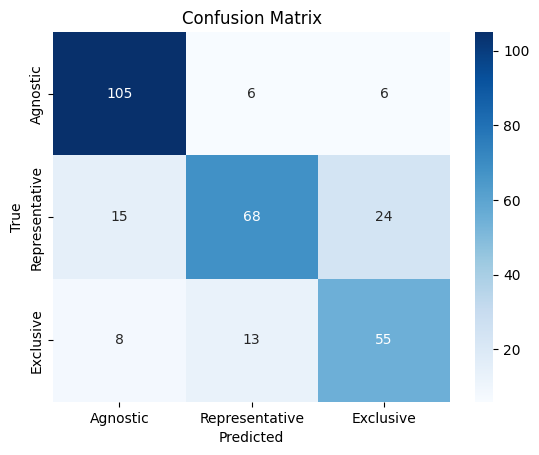

In [ ]:
df_val["predicted_label"] = [
    classify_full_pipeline(emb, score, threshold, mean_vectors)
    for emb, score in zip(df_val["embedding"], df_val["score"])
]

true_labels = df_val["label"]
pred_labels = df_val["predicted_label"]

#classification report
print(classification_report(true_labels, pred_labels))

#Confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=[
    "cultural agnostic", "cultural representative", "cultural exclusive"
])

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Agnostic", "Representative", "Exclusive"],
            yticklabels=["Agnostic", "Representative", "Exclusive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Predictions on test set

In [ ]:
df1["predicted_label"] = [
    classify_full_pipeline(emb, score, threshold, mean_vectors)
    for emb, score in zip(df1["embedding"], df1["score"])
]

In [ ]:
df1.to_csv("AleBERTs&FraBERT_output_modello2.csv", index=False) #save the csv with the predictions
files.download("AleBERTs&FraBERT_output_modello2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
'''df_val.to_csv("Validation_2.csv", index=False) #save the csv with the predictions
files.download("Validation_2.csv")'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# LM approach

## Dataset Preparation

In [ ]:
from transformers import RobertaModel, RobertaPreTrainedModel
import torch.nn as nn
import transformers

def set_all_seeds(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True)
    set_seed(seed)

set_all_seeds(42)


label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["label"])
df_val["label"] = label_encoder.transform(df_val["label"])

for col in ["name", "wikipedia_categories", "English_description"]:
    df_train[col] = df_train[col].astype(str)
    df_val[col] = df_val[col].astype(str)

def build_roberta_input(row):
    return (
        f"[NAME] {row['name']} </s> "
        f"[CATS] {row['wikipedia_categories']} </s> "
        f"[EN_DESC] {row['English_description']} </s>"
    )

df_train["text"] = df_train.apply(build_roberta_input, axis=1)
df_val["text"] = df_val.apply(build_roberta_input, axis=1)

train_ds = Dataset.from_pandas(df_train[["text", "label"]])
val_ds = Dataset.from_pandas(df_val[["text", "label"]])

model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds_tokenized = train_ds.map(tokenize_function, batched=True)
val_ds_tokenized = val_ds.map(tokenize_function, batched=True)

train_ds_tokenized = train_ds_tokenized.remove_columns(["text"]).with_format("torch")
val_ds_tokenized = val_ds_tokenized.remove_columns(["text"]).with_format("torch")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/6251 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

## Classifier Definition and Training of the Model

In [ ]:

class RobertaForCustomClassification(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Sequential(
            nn.Linear(config.hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, config.num_labels)
        )
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_token)
        x = self.classifier(x)

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(x, labels)

        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=x,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

config = AutoConfig.from_pretrained(model_name, num_labels=3)
model = RobertaForCustomClassification.from_pretrained(model_name, config=config)


accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"]
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


training_args = TrainingArguments(
    output_dir="cultural_classifier_model",
    num_train_epochs=8,
    per_device_train_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=1e-5,
    save_strategy="epoch",
    logging_dir="training_logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_tokenized,
    eval_dataset=val_ds_tokenized,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForCustomClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.3.bias', 'classifier.3.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<ipython-input-27-a6f11afa9d09>:67: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.955200,0.661663,0.743333,0.731573
2,0.611000,0.620589,0.726667,0.702195
3,0.485700,0.599492,0.750000,0.732712
4,0.408300,0.538539,0.810000,0.798215
5,0.340000,0.618495,0.790000,0.777922
6,0.291700,0.662658,0.800000,0.785780
7,0.254700,0.700581,0.786667,0.773414


TrainOutput(global_step=2737, training_loss=0.4780853516784601, metrics={'train_runtime': 728.8213, 'train_samples_per_second': 68.615, 'train_steps_per_second': 4.292, 'total_flos': 5763013553859072.0, 'train_loss': 0.4780853516784601, 'epoch': 7.0})

## Evaluation on validation set

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5385392308235168,
 'eval_accuracy': 0.81,
 'eval_f1': 0.7982153311933459,
 'eval_runtime': 1.297,
 'eval_samples_per_second': 231.302,
 'eval_steps_per_second': 29.298,
 'epoch': 7.0}

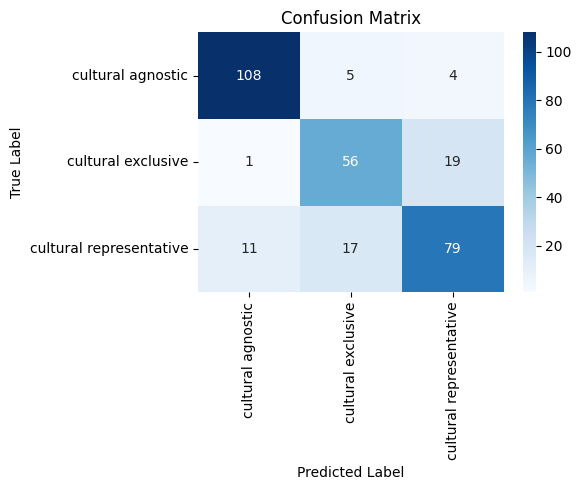

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

predictions = trainer.predict(val_ds_tokenized)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

labels = label_encoder.classes_

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [ ]:
'''df_val.to_csv("Validation_1.csv", index=False) #save the csv with the predictions
files.download("Validation_1.csv")'''

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Predictions on test set

In [ ]:

for col in ["name", "wikipedia_categories", "English_description"]:
    df2[col] = df2[col].astype(str)
df2["text"] = df2.apply(build_roberta_input, axis=1)

test_ds = Dataset.from_pandas(df2[["text"]])
test_ds = test_ds.map(tokenize_function, batched=True)
test_ds = test_ds.remove_columns(["text"]).with_format("torch")

predictions = trainer.predict(test_ds)
predicted_labels = np.argmax(predictions.predictions, axis=1)
df2["predicted_label"] = label_encoder.inverse_transform(predicted_labels)

df2.to_csv("AleBERTs&FraBERT_output_modello1.csv", index=False)

from google.colab import files
files.download("AleBERTs&FraBERT_output_modello1.csv")


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>